## Import

In [1]:
import os
import sys
import pickle
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math


In [2]:
print(torch.__version__)
print(pd.__version__)

2.6.0+cu118
2.2.3


## Config

In [93]:
config = {
    "seed": 0,
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
    "max_len": 384,  ##
    "batch_size": 1,
    "learning_rate": 1e-4,
    "weight_decay": 0.0,
    "mixed_precision": "bf16",
    "model_config_path": "../working/configs/pairwise.yaml",  # Adjust path as needed
    "epochs": 10,  ##
    "loss_power_scale": 1.0,
    "max_cycles": 1,
    "grad_clip": 0.1,
    "gradient_accumulation_steps": 1,
    "d_clamp": 30,
    "max_len_filter": 9999999,
    "min_len_filter": 10,
    "structural_violation_epoch": 50,
    "balance_weight": False,
    "n_tokens": 4,
    "d_model": 256,  ##
    "n_heads": 8,
    "dropout": 0.1,
    "d_ff": 1024, ##
    "norm_ratio": 0.25, ##
    "n_layers": 20 ##
}

## Set Sample Data To make Model

In [4]:
os.getcwd()

'c:\\Users\\solba\\Desktop\\25_1_Capstone1\\WuSubSol'

In [5]:
folder_path = '../pdb_pipeline'

train_labels = pd.read_csv(os.path.join(folder_path, 'pdb_labels_5models.csv'))

train_sequences = pd.read_csv(os.path.join(folder_path, 'pdb_sequences_5models.csv'))

print(train_labels.head())

print(train_sequences.head())


          ID resname  resid    x_1    y_1     z_1    x_2    y_2     z_2  \
0   124D_B_9       C      9 -0.471 -6.788  18.299 -0.471 -6.788  18.299   
1  124D_B_10       A     10 -5.581 -5.427  16.282 -5.581 -5.427  16.282   
2  124D_B_11       U     11 -7.964 -1.483  13.892 -7.964 -1.483  13.892   
3  124D_B_12       G     12 -8.050  3.242  11.526 -8.050  3.242  11.526   
4  124D_B_13       U     13 -5.350  7.000   8.973 -5.350  7.000   8.973   

     x_3    y_3     z_3    x_4    y_4     z_4    x_5    y_5     z_5  
0 -0.471 -6.788  18.299 -0.471 -6.788  18.299 -0.471 -6.788  18.299  
1 -5.581 -5.427  16.282 -5.581 -5.427  16.282 -5.581 -5.427  16.282  
2 -7.964 -1.483  13.892 -7.964 -1.483  13.892 -7.964 -1.483  13.892  
3 -8.050  3.242  11.526 -8.050  3.242  11.526 -8.050  3.242  11.526  
4 -5.350  7.000   8.973 -5.350  7.000   8.973 -5.350  7.000   8.973  
  target_id               sequence temporal_cutoff  description  all_sequences
0    124D_B               CAUGUGAC      1993-05-07

In [6]:
train_labels["pdb_id"] = train_labels["ID"].apply(lambda x: x.split("_")[0]+'_'+x.split("_")[1])
train_labels["pdb_id"]

0         124D_B
1         124D_B
2         124D_B
3         124D_B
4         124D_B
           ...  
250737    9MX5_C
250738    9MX5_C
250739    9MX5_C
250740    9MX5_C
250741    9MX5_C
Name: pdb_id, Length: 250742, dtype: object

In [7]:
all_xyz=[]

for pdb_id in tqdm(train_sequences['target_id']):
    df = train_labels[train_labels["pdb_id"]==pdb_id]
    #break
    xyz=df[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5',]].to_numpy().astype('float32')
    xyz[xyz<-1e17]=float('Nan');
    all_xyz.append(xyz)

# all_xyz[13]

100%|██████████| 3806/3806 [00:40<00:00, 94.02it/s] 


### filter data

In [8]:
# filter the data
# Filter and process data
filter_nan = []
max_len = 0
filter_ratio = 0 # All data are valid
for xyz in all_xyz:
    if len(xyz) > max_len:
        max_len = len(xyz)

    filter_nan.append((np.isnan(xyz).mean() <= filter_ratio) & \
                      (len(xyz)<config['max_len_filter']) & \
                      (len(xyz)>config['min_len_filter']))


print(f"Longest sequence in train: {max_len}")

filter_nan = np.array(filter_nan)
non_nan_indices = np.arange(len(filter_nan))[filter_nan]
print('remain sequences:', len(non_nan_indices))
train_sequences = train_sequences.loc[non_nan_indices].reset_index(drop=True)
non_nan_xyz=[all_xyz[i] for i in non_nan_indices]

Longest sequence in train: 2900
remain sequences: 2533


In [9]:
#pack data into a dictionary

data={
      "pdb_id":train_sequences['target_id'].to_list(),
      "sequence":train_sequences['sequence'].to_list(),
      "temporal_cutoff": train_sequences['temporal_cutoff'].to_list(),
      "description": train_sequences['description'].to_list(),
      "all_sequences": train_sequences['all_sequences'].to_list(),
      "xyz": non_nan_xyz
}
print(data['pdb_id'][1])
print(data['sequence'][1])
print(data['temporal_cutoff'][1])
print(data['description'][1])
print(data['all_sequences'][1])
# print(data['xyz'][1])

1A1T_B
GGACUAGCGGAGGCUAGUCC
1997-12-15
nan
nan


### Split Train / Validation set

In [10]:
# Split data into train and test
all_index = np.arange(len(data['sequence']))
cutoff_date = pd.Timestamp(config['cutoff_date'])
test_cutoff_date = pd.Timestamp(config['test_cutoff_date'])
train_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) <= cutoff_date]
test_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) > cutoff_date and pd.Timestamp(d) <= test_cutoff_date]

### To Pytorch Dataset

In [11]:
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval

def get_ct(bp,s):
    ct_matrix=np.zeros((len(s),len(s)))
    for b in bp:
        ct_matrix[b[0]-1,b[1]-1]=1
    return ct_matrix

class RNA3D_Dataset(Dataset):
    def __init__(self,indices,data):
        self.indices=indices
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}
        # self.tokens = {'A': 2, 'U':-2, 'G':3, 'C':-3}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):

        idx=self.indices[idx]
        sequence=[self.tokens[nt] for nt in (self.data['sequence'][idx])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        #get C1' xyz
        xyz=self.data['xyz'][idx]
        xyz=torch.tensor(np.array(xyz))


        if len(sequence)>config['max_len']:
            crop_start=np.random.randint(len(sequence)-config['max_len'])
            crop_end=crop_start+config['max_len']

            sequence=sequence[crop_start:crop_end]
            xyz=xyz[crop_start:crop_end]
        #center at first atom if first atom does not exit go until it does
        for i in range(len(xyz)):
            if (~torch.isnan(xyz[i])).all():
                break
        xyz=xyz-xyz[i]

        return {'pbd_id':self.data['pdb_id'][idx],
            'sequence':sequence,
                'xyz':xyz}

In [12]:
train_dataset=RNA3D_Dataset(train_index,data)
val_dataset=RNA3D_Dataset(test_index,data)

In [13]:
print(train_dataset[0]['xyz'][2])


tensor([-11.5840,  -1.9270,  -0.0570, -10.9290,   2.5640,   2.3630, -11.3600,
         -4.0740,  -0.0880, -10.9900,   2.7140,   1.7140, -10.7080,   4.4850,
         -0.1930])


In [14]:
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=1,shuffle=False)

print(train_dataset[0]['xyz'][2])


tensor([-11.5840,  -1.9270,  -0.0570, -10.9290,   2.5640,   2.3630, -11.3600,
         -4.0740,  -0.0880, -10.9900,   2.7140,   1.7140, -10.7080,   4.4850,
         -0.1930])


## Model definition

### Example with one data

In [37]:
num_seq = 1

src = train_dataset[num_seq]['sequence']
tgt = train_dataset[num_seq]['xyz']

print(src, len(src))
print(train_dataset[num_seq]['pbd_id'])
# print(tgt)

tensor([2, 2, 0, 1, 3, 0, 2, 1, 2, 2, 0, 2, 2, 1, 3, 0, 2, 3, 1, 1]) 20
1A1T_B


### Check Pairwise

21
GGCGUAAGGAUUACCUAUGCC
<class 'torch.Tensor'>
torch.Size([21, 21])


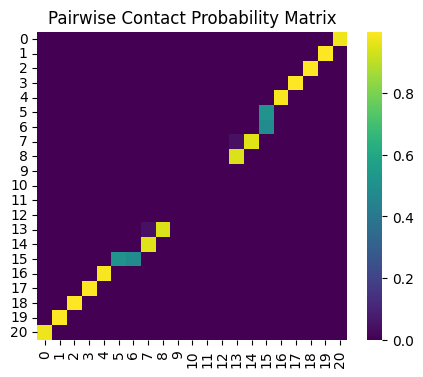

In [38]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

src = torch.tensor([2, 2, 1, 2, 3, 0, 0, 2, 2, 0, 3, 3, 0, 1, 1, 3, 0, 3, 2, 1, 1], dtype=torch.long)
# AUGC를 0123으로 매핑
nucleotide_map = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

str_A = ''.join([nucleotide_map[x.item()] for x in src])

print(len(str_A))
print(str_A)

md = RNA.md()

fc = RNA.fold_compound(str_A, md)

# predict Minmum Free Energy and corresponding secondary structure
# (ss, mfe) = 
# print(fc.mfe())
fc.pf()
B = torch.tensor(fc.bpp())

# B = torch.tensor(B)
B = B[1:,1:]
print(type(B))
print(B.shape)
B = B + B.T
# B = np.array(B, dtype=np.bool())
# print(B)

plt.figure(figsize=(5,4))
sns.heatmap(B, cmap='viridis', annot=False)  # annot=True로 설정하면 각 셀에 값 표시
plt.title('Pairwise Contact Probability Matrix')
plt.show()

# def get_pairwise_features(src, seq_len, d_model):
#     nucleotide_map = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

#     # print("pairwise",src)
#     src = src.squeeze(0)
#     str_seq = ''.join([nucleotide_map[x.item()] for x in src])
#     # print("str_seq",str_seq)
    
#     md = RNA.md()
#     fc = RNA.fold_compound(str_seq, md)
#     fc.pf() ##???

#     pair_matrix = torch.tensor(fc.bpp(), dtype=torch.float32)
#     # print("pair_matrix",pair_matrix)
#     pair_matrix = pair_matrix[1:,1:] # remove first row and column 0 index in bpp is always 0
#     pair_matrix = pair_matrix + pair_matrix.T # symmetric matrix

#     pair_matrix = pair_matrix.unsqueeze(0).unsqueeze(0)
#     pair_matrix = F.interpolate(pair_matrix, size=(d_model, d_model), mode='bilinear', align_corners=False)
#     # pair_matrix = F.interpolate(pair_matrix, size=(d_model, d_model), mode='nearest', align_corners=False)

#     pair_matrix = pair_matrix.squeeze()
#     # print("pair_matrix",pair_matrix.shape)

#     return pair_matrix

### MSA Module

In [39]:
class OuterProductMean(nn.Module):
    def __init__(self, in_dim=256, dim_msa=32, pairwise_dim=64):
        super(OuterProductMean, self).__init__()
        self.proj_down1 = nn.Linear(in_dim, dim_msa)
        self.proj_down2 = nn.Linear(dim_msa ** 2, pairwise_dim)

    def forward(self,seq_rep, pair_rep=None):
        seq_rep=self.proj_down1(seq_rep)
        outer_product = torch.einsum('bid,bjc -> bijcd', seq_rep, seq_rep)
        outer_product = rearrange(outer_product, 'b i j c d -> b i j (c d)')
        outer_product = self.proj_down2(outer_product)

        if pair_rep is not None:
            outer_product=outer_product+pair_rep

        return outer_product

### Back Bone

In [94]:
import RNA
import torch.nn.functional as F
from einops import rearrange, repeat, reduce


def pos_encoder(seq_len, d_model):
    result = torch.zeros(seq_len, d_model)

    for pos in range(seq_len):
        for i in range(d_model):
            if i % 2 == 0:
                result[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
            else:
                result[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

    return result

class RelativePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_relative_position=32):
        super().__init__()
        self.max_relative_position = max_relative_position
        # 상대적 위치 범위: [-max_relative_position, max_relative_position]
        self.num_positions = 2 * max_relative_position + 1
        self.relative_embedding = nn.Embedding(self.num_positions, d_model)
        
    def forward(self, seq_len):
        # 모든 가능한 위치 쌍 간의 상대적 거리 계산
        range_vec = torch.arange(seq_len)
        distance_mat = range_vec[:, None] - range_vec[None, :]  # shape: [seq_len, seq_len]
        
        # 상대 거리를 [-max_relative_position, max_relative_position] 범위로 제한
        distance_mat_clipped = torch.clamp(
            distance_mat, -self.max_relative_position, self.max_relative_position)
        
        # 인덱스 변환: [-max_relative_position, max_relative_position] -> [0, 2*max_relative_position]
        final_mat = distance_mat_clipped + self.max_relative_position
        
        # 상대적 위치에 대한 임베딩 조회
        embeddings = self.relative_embedding(final_mat.to(torch.long))
        
        return embeddings  # shape: [seq_len, seq_len, d_model]

class ConstrainedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_relative_position=32, constrained_position=4):
        super().__init__()
        self.max_relative_position = max_relative_position
        self.relative_embedding = nn.Embedding(2 * max_relative_position + 1, d_model)
        self.constrained_position = constrained_position

    def forward(self, seq_len):

        return pos_encoding(seq_len, self.d_model)
        

class EmbedSequence(nn.Module):
    def __init__(self, d_model, n_tokens = config['n_tokens']):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(n_tokens, d_model)
        # self.pos_encoding = PosEncoding(seq_len, d_model)
        
    def forward(self, sequence):
        seq_len = len(sequence.squeeze())
        # print(seq_len)
        pos_encoding = pos_encoder(seq_len, self.d_model)
        sequence = sequence.long()
        return self.embedding(sequence) + pos_encoding
    

class MultiheadAtt(nn.Module):
    def __init__(self, d_model, n_heads=8, dropout=None):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)

        self.w_q = nn.Linear(d_model, n_heads * self.d_head)
        self.w_k = nn.Linear(d_model, n_heads * self.d_head)
        self.w_v = nn.Linear(d_model, n_heads * self.d_head)

        # self.w_o = nn.Linear(n_heads * self.d_head, d_model)
        
    def forward(self, query, key, value):
        # print('query.shape',query.shape)
        batch_size, length, d_model = query.size()
        
        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)

        q = q.view(batch_size, length, self.n_heads, self.d_head)
        k = k.view(batch_size, length, self.n_heads, self.d_head)
        v = v.view(batch_size, length, self.n_heads, self.d_head)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)  
        output = torch.matmul(scores, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, length, -1)
        
        return output


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=None):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.w_1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.w_2(x)

        return x


def residual_connection_one(x, sublayer):
    return x + sublayer(x)

def residual_connection_attention(x, sublayer):
    return x + sublayer(x,x,x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0, norm_type='post_ln'):
        super().__init__()
        
        self.d_ff = config['d_ff']
        
        if (norm_type == 'post_ln') or (norm_type == 'pre_ln'):
            self.norm_type = norm_type
        else:
            raise ValueError("Invalid norm_type")

        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        
        self.attention = MultiheadAtt(d_model, n_heads, dropout)
        self.feedforward = FeedForward(d_model, self.d_ff, dropout)
        self.activation = nn.ReLU()

    def forward(self, src, pairwise_feature=None):
        # src = residual_connection(src, self.encoder(src))
        norm_type = self.norm_type

        if norm_type == 'post_ln':
            src = residual_connection_attention(src, self.attention)
            src = self.norm_1(src)
            src = self.activation(src)
            src = residual_connection_one(src, self.feedforward)
            src = self.norm_2(src)
            src = self.activation(src)

        elif norm_type == 'pre_ln':
            src_temp = src
            src = self.norm_1(src)
            src = self.attention(src,src,src) + src_temp
            src = self.activation(src)
            src_temp = src
            src = self.norm_2(src)
            src = self.feedforward(src) + src_temp
            src = self.activation(src)

        return src


class WuSubSol(nn.Module):
    def __init__(self, config):
        super(WuSubSol, self).__init__()
        self.config = config
        self.n_layers = config['n_layers']
        self.d_model = config['d_model']

        self.norm_ratio = config['norm_ratio']
        if (self.n_layers * self.norm_ratio).is_integer():
            self.n_post_ln = int(self.n_layers * self.norm_ratio)
        else:
            print("Invalid norm_ratio")
            exit()
        
        self.embedding = EmbedSequence(self.d_model)


        self.encoder_layers = []
        for i in range(self.n_post_ln):
            self.encoder_layers.append(EncoderLayer(self.d_model, config['n_heads'], config['dropout'], 'post_ln'))
        for i in range(self.n_layers - self.n_post_ln):
            self.encoder_layers.append(EncoderLayer(self.d_model, config['n_heads'], config['dropout'], 'pre_ln'))

        self.encoder_layers = nn.ModuleList(self.encoder_layers)

        self.final_linear = nn.Linear(self.d_model, 15)

        print(f"{self.n_layers} layers of encoder constructed")

    def forward(self, src):
        pairwise_feature = None

        src = self.embedding(src) # L*d_model
        # print('after embedding', src.shape)


        for i,layer in enumerate(self.encoder_layers):
            # print("before",src.shape)
            src = layer(src, pairwise_feature)
            # print("after",src.shape)

        src = self.final_linear(src).squeeze()
        
        # print('final tensor-Shape : ', src.shape)

        return src



In [95]:
model = WuSubSol(config)
print(model)


20 layers of encoder constructed
WuSubSol(
  (embedding): EmbedSequence(
    (embedding): Embedding(4, 256)
  )
  (encoder_layers): ModuleList(
    (0-19): 20 x EncoderLayer(
      (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAtt(
        (dropout): Dropout(p=0.1, inplace=False)
        (w_q): Linear(in_features=256, out_features=256, bias=True)
        (w_k): Linear(in_features=256, out_features=256, bias=True)
        (w_v): Linear(in_features=256, out_features=256, bias=True)
      )
      (feedforward): FeedForward(
        (dropout): Dropout(p=0.1, inplace=False)
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, out_features=256, bias=True)
        (activation): ReLU()
      )
      (activation): ReLU()
    )
  )
  (final_linear): Linear(in_features=256, out_features=15, bias=True)
)


In [68]:

from torchviz import make_dot
A = torch.tensor([2, 2, 1, 2, 3, 0, 0, 2, 2, 0, 3, 3, 0, 1, 1, 3, 0, 3, 2, 1, 1], dtype=torch.float32, requires_grad=True)
A = A.unsqueeze(0) # batch dim 반영
model = WuSubSol(config)
# 모델에 맞는 더미 입력 데이터 생성

y = model(A)
# make_dot(y, params=dict(list(model.named_parameters()) + [('x', A)]))
# make_dot(y.mean(), params=dict(list(model.named_parameters()) + [('x', A)]))


8 layers of encoder constructed


## Training Loop

### Define Loss Function

In [96]:
def calculate_distance_matrix(X,Y,epsilon=1e-4):
    return (torch.square(X[:,None]-Y[None,:])+epsilon).sum(-1).sqrt()

def dRMAE(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)

    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])

    return rmsd.mean()/Z

def align_svd_mae(input, target, Z=10):
    """
    Aligns the input (Nx3) to target (Nx3) using SVD-based Procrustes alignment
    and computes RMSD loss.

    Args:
        input (torch.Tensor): Nx3 tensor representing the input points.
        target (torch.Tensor): Nx3 tensor representing the target points.

    Returns:
        aligned_input (torch.Tensor): Nx3 aligned input.
        rmsd_loss (torch.Tensor): RMSD loss.
    """
    # print('input-Shape', input.shape)
    # print('output-Shape', target.shape)
    # target = target[:, :3]
    assert input.shape == target.shape, "Input and target must have the same shape"

    #mask
    mask=~torch.isnan(target.sum(-1))

    input=input[mask]
    target=target[mask]

    # Compute centroids
    centroid_input = input.mean(dim=0, keepdim=True)
    centroid_target = target.mean(dim=0, keepdim=True)

    # Center the points
    input_centered = input - centroid_input.detach()
    target_centered = target - centroid_target

    # Compute covariance matrix
    cov_matrix = input_centered.T @ target_centered

    # SVD to find optimal rotation
    U, S, Vt = torch.svd(cov_matrix)

    # Compute rotation matrix
    R = Vt @ U.T

    # Ensure a proper rotation (det(R) = 1, no reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt @ U.T

    # Rotate input
    aligned_input = (input_centered @ R.T.detach()) + centroid_target.detach()

    # # Compute RMSD loss
    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # return aligned_input, rmsd_loss
    return torch.abs(aligned_input-target).mean()/Z

def align_svd_rmsd(input, target):
    """
    Aligns the input (Nx3) to target (Nx3) using SVD-based Procrustes alignment
    and computes RMSD loss.

    Args:
        input (torch.Tensor): Nx3 tensor representing the input points.
        target (torch.Tensor): Nx3 tensor representing the target points.

    Returns:
        aligned_input (torch.Tensor): Nx3 aligned input.
        rmsd_loss (torch.Tensor): RMSD loss.
    """
    # print('input-Shape', input.shape)
    # print('output-Shape', target.shape)
    # target = target[:,:3]
    assert input.shape == target.shape, "Input and target must have the same shape"

    #mask
    mask=~torch.isnan(target.sum(-1))
    
    
    input=input[mask]
    target=target[mask]

    # Compute centroids
    centroid_input = input.mean(dim=0, keepdim=True)
    centroid_target = target.mean(dim=0, keepdim=True)

    # Center the points
    input_centered = input - centroid_input.detach()
    target_centered = target - centroid_target

    # Compute covariance matrix
    cov_matrix = input_centered.T @ target_centered

    # SVD to find optimal rotation
    U, S, Vt = torch.svd(cov_matrix)

    # Compute rotation matrix
    R = Vt @ U.T

    # Ensure a proper rotation (det(R) = 1, no reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt @ U.T

    # Rotate input
    aligned_input = (input_centered @ R.T.detach()) + centroid_target.detach()

    # # Compute RMSD loss
    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # return aligned_input, rmsd_loss
    return torch.square(aligned_input-target).mean().sqrt()

def compute_lddt(ground_truth_atoms, predicted_atoms, cutoff=30.0, thresholds=[1.0, 2.0, 4.0, 8.0]):
    """
    Computes the lDDT score between ground truth and predicted atoms.

    Parameters:
        ground_truth_atoms (np.array): Nx3 array of ground truth atom coordinates.
        predicted_atoms (np.array): Nx3 array of predicted atom coordinates.
        cutoff (float): Distance cutoff in Ångstroms to consider neighbors. Default is 30 Å.
        thresholds (list): List of thresholds in Ångstroms for the lDDT computation. Default is [0.5, 1.0, 2.0, 4.0].

    Returns:
        float: The lDDT score.
    """
    # Number of atoms
    num_atoms = ground_truth_atoms.shape[0]

    # Initialize array to store lDDT fractions for each threshold
    fractions = np.zeros(len(thresholds))

    for i in range(num_atoms):
        # Get the distances from atom i to all other atoms for both ground truth and predicted atoms
        gt_distances = np.linalg.norm(ground_truth_atoms[i] - ground_truth_atoms, axis=1)
        pred_distances = np.linalg.norm(predicted_atoms[i] - predicted_atoms, axis=1)

        # print(gt_distances)
        # print(pred_distances)
        # exit()
        # Apply the cutoff to consider only distances within the cutoff range
        mask = (gt_distances > 0) & (gt_distances < cutoff)

        # Calculate the absolute difference between ground truth and predicted distances
        distance_diff = np.abs(gt_distances[mask] - pred_distances[mask])

        # Filter out any NaN values from the distance difference calculation
        valid_mask = ~np.isnan(distance_diff)
        distance_diff = distance_diff[valid_mask]

        # Compute the fractions for each threshold
        for j, threshold in enumerate(thresholds):
            if len(distance_diff)>0:
                fractions[j] += np.mean(distance_diff < threshold)
    # print(fractions)
    # print(num_atoms)

    # Average the fractions over the number of atoms
    fractions /= num_atoms

    # The final lDDT score is the average of these fractions
    lddt_score = np.mean(fractions)

    return lddt_score

### Training SetUp

In [97]:
from tqdm import tqdm

epochs=config['epochs']
# cos_epoch=config['cos_epoch']
cos_epoch=5


best_loss=np.inf
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0, lr=0.0002) #no weight decay following AF

batch_size=1

#for cycle in range(2):

criterion=torch.nn.CrossEntropyLoss(reduction='none')

#scaler = GradScaler()

schedule=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(epochs-cos_epoch)*len(train_loader)//batch_size)


### Train

In [98]:
version_name = 'ribonanza2_5models'

best_val_loss=99999999999
loss_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss'])

# print(type(train_loader))

epochs = 10

for epoch in range(epochs):
    model.train()
    tbar=tqdm(train_loader)
    total_loss=0
    train_loss=0

    for idx, batch in enumerate(tbar):
        #try:
        sequence=batch['sequence']#.cuda()
        gt_xyz=batch['xyz'].squeeze()#.cuda()

        mask=~torch.isnan(gt_xyz)
        gt_xyz[torch.isnan(gt_xyz)]=0
        # print('start sequence',sequence.shape)

        pred_xyz = model(sequence).squeeze()

        loss = dRMAE(pred_xyz,pred_xyz,gt_xyz,gt_xyz) + align_svd_mae(pred_xyz, gt_xyz)

        if loss!=loss:
            stop

        try:
          (loss/batch_size).backward()
        except:
          print(gt_xyz.shape)

        if (idx+1)%batch_size==0 or idx+1 == len(tbar):

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            optimizer.zero_grad()
            # scaler.scale(loss/batch_size).backward()
            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            # scaler.step(optimizer)
            # scaler.update()

            if (epoch+1)>cos_epoch:
                schedule.step()
        
        total_loss += loss
        train_loss = total_loss/(idx+1)

        tbar.set_description(f"Epoch {epoch + 1} Loss: {total_loss/(idx+1)}")

    ### Validation
    tbar=tqdm(val_loader)
      
    model.eval()
    val_preds=[]
    val_loss=0

    for idx, batch in enumerate(tbar):
        sequence=batch['sequence']#.cuda()
        gt_xyz=batch['xyz'].squeeze()#.cuda().squeeze()

        with torch.no_grad():
            pred_xyz=model(sequence).squeeze()
            loss = dRMAE(pred_xyz,pred_xyz,gt_xyz,gt_xyz) + align_svd_mae(pred_xyz, gt_xyz)

        val_loss+=loss
        val_preds.append([gt_xyz.cpu().numpy(),pred_xyz.cpu().numpy()])

    val_loss=val_loss/len(tbar)
    print(f"val loss: {val_loss}")

    save_df = pd.DataFrame({'epoch': [epoch], 'train_loss': [train_loss], 'val_loss': [val_loss]})
    loss_df = pd.concat([loss_df, save_df], ignore_index=True)

    ## Check Best Loss .pt and Save
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        best_preds=val_preds
        torch.save(model.state_dict(),f'/Save_Data/{version_name}_{epochs}_best.pt')

    # 1.053595052265986 train loss after epoch 0
torch.save(model.state_dict(),f'/Save_Data/{version_name}_{epochs}_last.pt')

# Save Loss,

loss_df.to_csv(f'/Save_Data/{version_name}_{epochs}_loss.csv', index=False)

  0%|          | 0/1288 [00:00<?, ?it/s]

Epoch 1 Loss: 6.340250492095947:   6%|▋         | 81/1288 [00:20<05:00,  4.02it/s] 


KeyboardInterrupt: 